<a href="https://colab.research.google.com/github/Rikiriyandi/WisataTasik/blob/main/Lampiran_Untuk_Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title 1.1.1. Mount Google Drive
# Mount Google Drive untuk mengakses dataset
from google.colab import drive
drive.mount('/content/drive')

# @title 1.2.1. Impor Pustaka
import os
import glob # Untuk mencari path file
import cv2 # OpenCV untuk pengolahan citra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog # Untuk HOG
from skimage import exposure # Untuk visualisasi HOG
from sklearn.model_selection import train_test_split, GridSearchCV # train_test_split tidak akan dipakai untuk pembagian data utama
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.applications import MobileNetV2 # Contoh pre-trained model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Mengatur seed untuk reproduktifitas (opsional tapi baik untuk penelitian)
np.random.seed(42)

Mounted at /content/drive


In [2]:
# @title 2.1.1. Atur dan Verifikasi Path Dataset
# Path ke dataset Anda di Google Drive
dataset_path = '/content/drive/MyDrive/dataset_tanaman_herbal'

print(f"Path dataset diatur ke: {dataset_path}")

# Verifikasi apakah path dataset ada
if os.path.exists(dataset_path) and os.path.isdir(dataset_path):
    print(f"Dataset ditemukan di {dataset_path}")
    print("Isi direktori dataset:")
    for item in os.listdir(dataset_path):
        print(f"- {item}")
else:
    print(f"Error: Direktori dataset tidak ditemukan di {dataset_path}.")
    print("Pastikan path sudah benar dan Google Drive telah ter-mount dengan sukses.")
    print("Jika dataset berada dalam folder zip, pastikan sudah diekstrak.")

Path dataset diatur ke: /content/drive/MyDrive/dataset_tanaman_herbal
Dataset ditemukan di /content/drive/MyDrive/dataset_tanaman_herbal
Isi direktori dataset:
- Data Training
- Data Testing


In [3]:
# @title 2.2.1. Pemuatan Path Citra dan Label (Diperbarui untuk struktur Training/Testing)
image_paths_train = []
labels_train = []
image_paths_test = []
labels_test = []

all_class_names = [] # Untuk menyimpan semua nama kelas yang ditemukan

if os.path.exists(dataset_path) and os.path.isdir(dataset_path):
    # Proses Data Training
    train_dir = os.path.join(dataset_path, 'Data Training')
    if os.path.exists(train_dir) and os.path.isdir(train_dir):
        class_names_train = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
        print(f"\nKelas yang ditemukan di Data Training: {class_names_train}")
        for class_name in class_names_train:
            all_class_names.append(class_name) # Tambahkan ke daftar semua kelas
            class_path = os.path.join(train_dir, class_name)
            for image_name in glob.glob(os.path.join(class_path, '*.*')):
                image_paths_train.append(image_name)
                labels_train.append(class_name)
        print(f"Total citra latih dimuat: {len(image_paths_train)}")
        print(f"Total label latih dimuat: {len(labels_train)}")
    else:
        print(f"Peringatan: Direktori 'Data Training' tidak ditemukan di {dataset_path}.")

    # Proses Data Testing
    test_dir = os.path.join(dataset_path, 'Data Testing')
    if os.path.exists(test_dir) and os.path.isdir(test_dir):
        class_names_test = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
        print(f"\nKelas yang ditemukan di Data Testing: {class_names_test}")
        for class_name in class_names_test:
            # Pastikan kelas di testing sudah ada di training, atau tambahkan jika ada kelas baru (jarang terjadi)
            if class_name not in all_class_names:
                all_class_names.append(class_name)
            class_path = os.path.join(test_dir, class_name)
            for image_name in glob.glob(os.path.join(class_path, '*.*')):
                image_paths_test.append(image_name)
                labels_test.append(class_name)
        print(f"Total citra uji dimuat: {len(image_paths_test)}")
        print(f"Total label uji dimuat: {len(labels_test)}")
    else:
        print(f"Peringatan: Direktori 'Data Testing' tidak ditemukan di {dataset_path}.")

    if not image_paths_train and not image_paths_test:
        print("Tidak ada citra yang ditemukan di Data Training atau Data Testing. Periksa kembali path dataset dan struktur foldernya.")
    else:
        # Gabungkan semua label untuk memastikan LabelEncoder melihat semua kelas yang mungkin
        all_labels_combined = labels_train + labels_test
        label_encoder = LabelEncoder()
        label_encoder.fit(all_labels_combined) # Fit encoder pada semua label yang mungkin ada

        encoded_labels_train = label_encoder.transform(labels_train)
        encoded_labels_test = label_encoder.transform(labels_test)

        print(f"\nContoh label asli (latih): {labels_train[:5]}")
        print(f"Contoh label terenkode (latih): {encoded_labels_train[:5]}")
        print(f"Contoh label asli (uji): {labels_test[:5]}")
        print(f"Contoh label terenkode (uji): {encoded_labels_test[:5]}")
        print(f"Mapping kelas: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
else:
    print(f"Error: Direktori dataset {dataset_path} tidak ditemukan atau bukan direktori. Pemuatan dataset gagal.")
    class_names_original_cm = [] # Inisialisasi jika path tidak ada
    encoded_labels_train = np.array([])
    encoded_labels_test = np.array([])



Kelas yang ditemukan di Data Training: ['Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih', 'Daun Sirsak', 'Lidah Buaya', 'Teh Hijau']
Total citra latih dimuat: 800
Total label latih dimuat: 800

Kelas yang ditemukan di Data Testing: ['Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih', 'Daun Sirsak', 'Lidah Buaya', 'Teh Hijau']
Total citra uji dimuat: 200
Total label uji dimuat: 200

Contoh label asli (latih): ['Daun Jambu Biji', 'Daun Jambu Biji', 'Daun Jambu Biji', 'Daun Jambu Biji', 'Daun Jambu Biji']
Contoh label terenkode (latih): [0 0 0 0 0]
Contoh label asli (uji): ['Daun Jambu Biji', 'Daun Jambu Biji', 'Daun Jambu Biji', 'Daun Jambu Biji', 'Daun Jambu Biji']
Contoh label terenkode (uji): [0 0 0 0 0]
Mapping kelas: {np.str_('Daun Jambu Biji'): np.int64(0), np.str_('Daun Kari'): np.int64(1), np.str_('Daun Kemangi'): np.int64(2), np.str_('Daun Kunyit'): np.int64(3), np.str_('

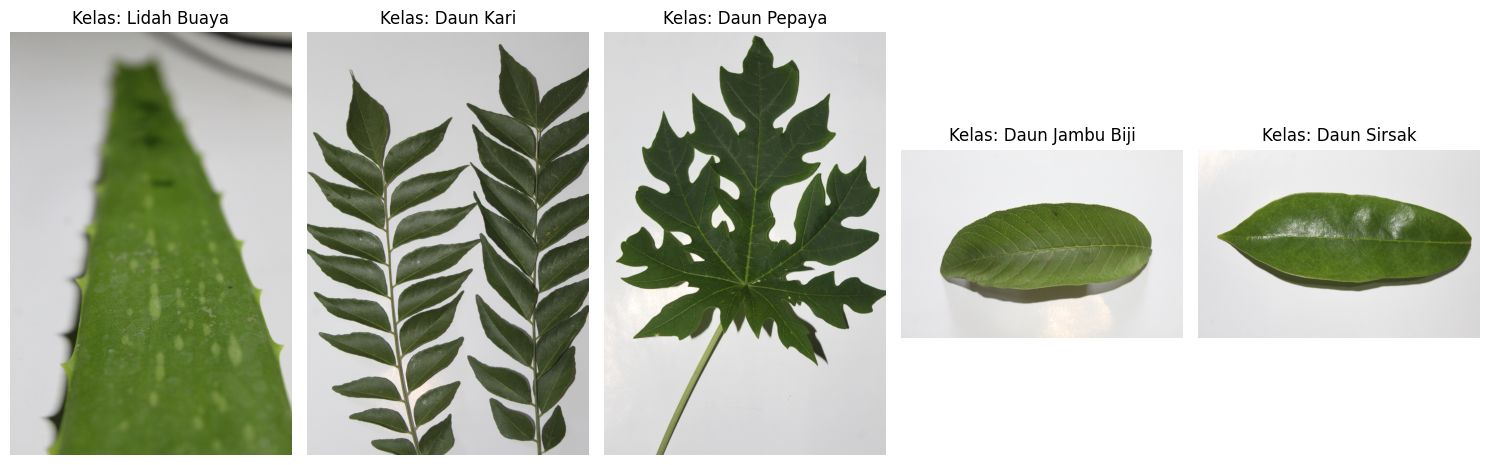

In [4]:
# @title 2.3.1. Tampilkan Contoh Citra
# Ambil contoh citra dari set training untuk visualisasi
if image_paths_train:
    num_samples_to_show = 5
    plt.figure(figsize=(15, 5))

    unique_labels_to_sample = np.unique(labels_train)

    if not unique_labels_to_sample.size:
        print("Tidak ada label unik untuk ditampilkan dari data training.")
    elif len(unique_labels_to_sample) < num_samples_to_show:
        samples_indices = [np.where(np.array(labels_train) == label)[0][0] for label in unique_labels_to_sample] # Ambil indeks pertama
        num_samples_to_show = len(unique_labels_to_sample)
    else:
        sampled_labels = np.random.choice(unique_labels_to_sample, size=num_samples_to_show, replace=False)
        samples_indices = [np.where(np.array(labels_train) == label)[0][0] for label in sampled_labels] # Ambil indeks pertama


    for i, idx in enumerate(samples_indices):
        img = cv2.imread(image_paths_train[idx])
        if img is None:
            print(f"Gagal memuat gambar: {image_paths_train[idx]}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples_to_show, i + 1)
        plt.imshow(img)
        plt.title(f"Kelas: {labels_train[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada citra training untuk ditampilkan.")



In [5]:
# @title 2.5.1. Buat Tabel Ikhtisar Dataset
if labels_train or labels_test:
    # Gabungkan label training dan testing untuk ikhtisar keseluruhan
    all_labels_for_overview = labels_train + labels_test
    label_counts = pd.Series(all_labels_for_overview).value_counts().sort_index()
    dataset_overview_df = pd.DataFrame({'Nama Kelas': label_counts.index, 'Jumlah Citra': label_counts.values})

    print("\n--- Ikhtisar Dataset Keseluruhan ---")
    print(dataset_overview_df.to_string())

    # Ikhtisar terpisah untuk training dan testing (opsional)
    if labels_train:
        train_label_counts = pd.Series(labels_train).value_counts().sort_index()
        train_overview_df = pd.DataFrame({'Nama Kelas': train_label_counts.index, 'Jumlah Citra': train_label_counts.values})
        print("\n--- Ikhtisar Dataset Training ---")
        print(train_overview_df.to_string())

    if labels_test:
        test_label_counts = pd.Series(labels_test).value_counts().sort_index()
        test_overview_df = pd.DataFrame({'Nama Kelas': test_label_counts.index, 'Jumlah Citra': test_label_counts.values})
        print("\n--- Ikhtisar Dataset Testing ---")
        print(test_overview_df.to_string())
else:
    print("Tidak ada data label untuk membuat ikhtisar.")


--- Ikhtisar Dataset Keseluruhan ---
        Nama Kelas  Jumlah Citra
0  Daun Jambu Biji           100
1        Daun Kari           100
2     Daun Kemangi           100
3      Daun Kunyit           100
4        Daun Mint           100
5      Daun Pepaya           100
6       Daun Sirih           100
7      Daun Sirsak           100
8      Lidah Buaya           100
9        Teh Hijau           100

--- Ikhtisar Dataset Training ---
        Nama Kelas  Jumlah Citra
0  Daun Jambu Biji            80
1        Daun Kari            80
2     Daun Kemangi            80
3      Daun Kunyit            80
4        Daun Mint            80
5      Daun Pepaya            80
6       Daun Sirih            80
7      Daun Sirsak            80
8      Lidah Buaya            80
9        Teh Hijau            80

--- Ikhtisar Dataset Testing ---
        Nama Kelas  Jumlah Citra
0  Daun Jambu Biji            20
1        Daun Kari            20
2     Daun Kemangi            20
3      Daun Kunyit            20
4 

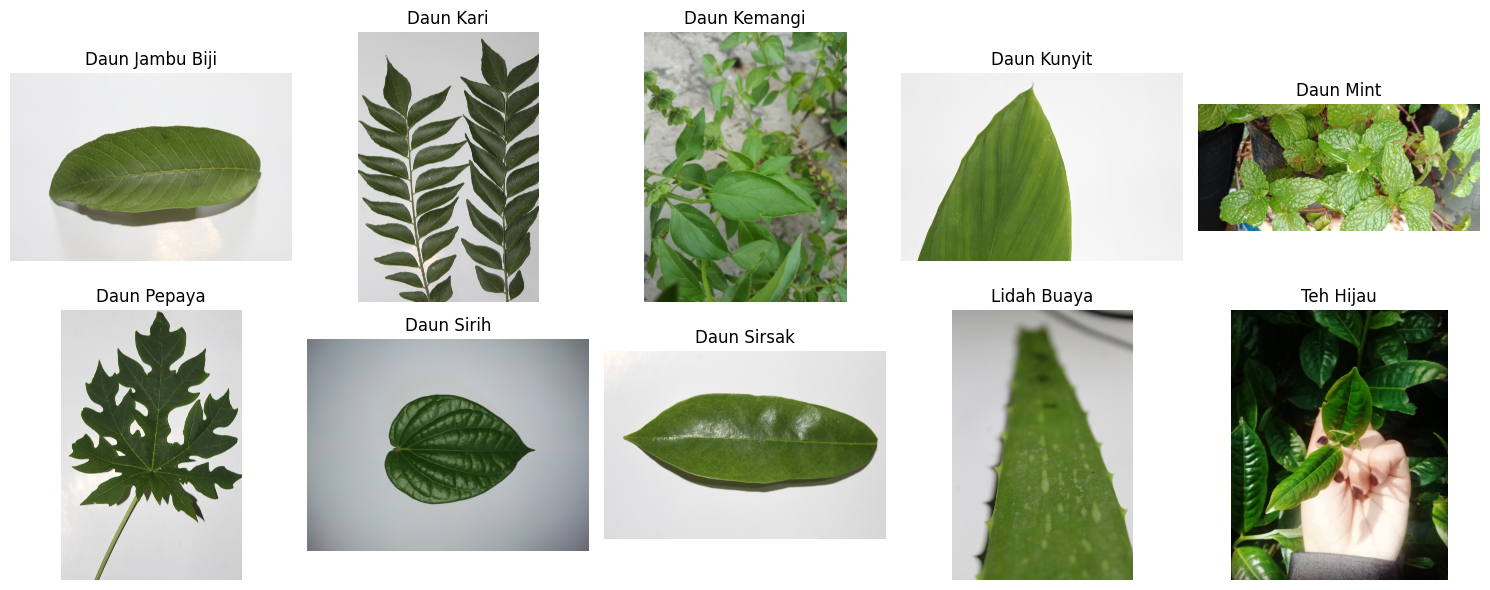

In [6]:
# @title 2.4.1. Tampilkan 1 Citra per Kelas
# Ambil satu gambar per label, tampilkan dalam subplot
if image_paths_train and labels_train and 'label_encoder' in globals():
    unique_labels = label_encoder.classes_
    num_classes = len(unique_labels)

    if num_classes == 0:
        print("Tidak ada kelas yang ditemukan dalam data training.")
    else:
        # Menentukan ukuran grid untuk subplot
        cols = 5 # Anda bisa ubah jumlah kolom sesuai keinginan
        rows = (num_classes + cols - 1) // cols # Hitung jumlah baris yang dibutuhkan

        plt.figure(figsize=(cols * 3, rows * 3)) # Sesuaikan ukuran figure

        # Dictionary untuk menyimpan indeks gambar pertama yang ditemukan untuk setiap label
        label_image_indices = {}

        # Temukan indeks gambar pertama untuk setiap label dalam data training
        for i, label in enumerate(labels_train):
            if label not in label_image_indices:
                label_image_indices[label] = i

        # Tampilkan satu gambar per label
        for i, label in enumerate(unique_labels):
            if label in label_image_indices:
                idx = label_image_indices[label]
                img_path = image_paths_train[idx]

                img = cv2.imread(img_path)
                if img is None:
                    print(f"Gagal memuat gambar untuk kelas {label}: {img_path}")
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Konversi dari BGR ke RGB untuk tampilan Matplotlib

                plt.subplot(rows, cols, i + 1)
                plt.imshow(img)
                plt.title(label)
                plt.axis('off')
            else:
                 print(f"Tidak ada gambar yang ditemukan di data training untuk kelas: {label}")


        plt.tight_layout()
        plt.show()

elif not image_paths_train:
    print("Tidak ada path citra training untuk ditampilkan.")
elif not labels_train:
     print("Tidak ada label training untuk ditampilkan.")
elif 'label_encoder' not in globals():
     print("Objek label_encoder belum dibuat. Pastikan sel sebelumnya sudah dijalankan.")

In [7]:
# @title 3.1. Fungsi Pra-pemrosesan Citra
def preprocess_image(image_path, target_size=(256, 256)):
    """
    Memuat citra, mengubah ukuran, dan mengonversi ke skala keabuan.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Gagal memuat citra di {image_path}")
            return None

        # 1. Resizing
        image_resized = cv2.resize(image, target_size)

        # 2. Grayscale Conversion
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

        # (Opsional) Peningkatan Kualitas Citra - contoh Gaussian Blur
        # image_gray = cv2.GaussianBlur(image_gray, (5,5), 0)

        return image_gray
    except Exception as e:
        print(f"Error saat memproses citra {image_path}: {e}")
        return None

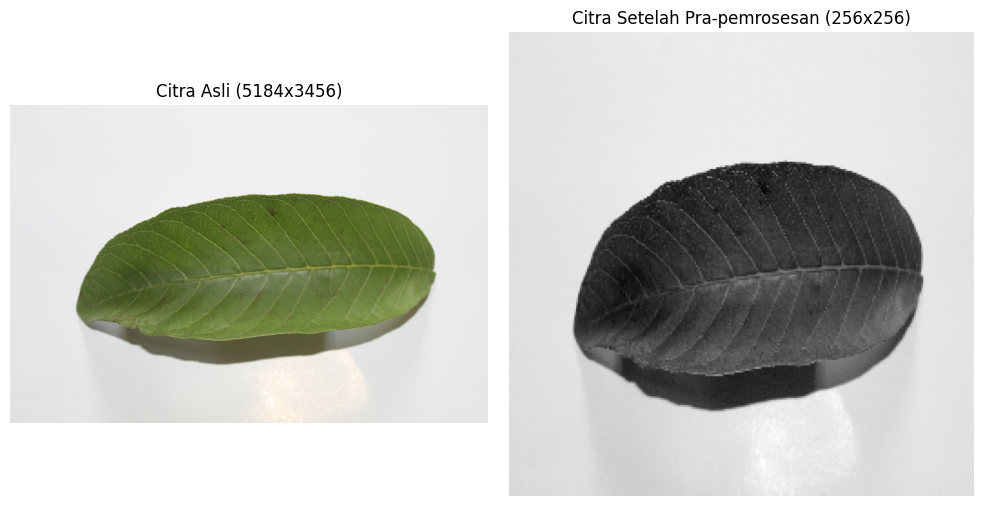

In [8]:
# @title 3.2. Demonstrasi Pra-pemrosesan
if image_paths_train: # Gunakan salah satu gambar dari set training untuk demonstrasi
    sample_image_path = image_paths_train[0] # Ambil contoh citra pertama dari training
    original_image = cv2.imread(sample_image_path)

    if original_image is not None:
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        preprocessed_image_gray = preprocess_image(sample_image_path)

        if preprocessed_image_gray is not None:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_image_rgb)
            plt.title(f"Citra Asli ({original_image.shape[1]}x{original_image.shape[0]})")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(preprocessed_image_gray, cmap='gray')
            plt.title(f"Citra Setelah Pra-pemrosesan ({preprocessed_image_gray.shape[1]}x{preprocessed_image_gray.shape[0]})")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print(f"Gagal memproses contoh citra: {sample_image_path}")
    else:
        print(f"Gagal memuat contoh citra asli: {sample_image_path}")
else:
    print("Tidak ada citra training untuk demonstrasi pra-pemrosesan.")

In [9]:
# @title 3.3. Terapkan Pra-pemrosesan ke Semua Citra (Training dan Testing)
preprocessed_images_train_gray = []
valid_labels_train_preprocessed = []

if image_paths_train and encoded_labels_train.size > 0:
    print("\n--- Pra-pemrosesan Citra Training ---")
    for i, img_path in enumerate(image_paths_train):
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            preprocessed_images_train_gray.append(processed_img)
            valid_labels_train_preprocessed.append(encoded_labels_train[i])

    preprocessed_images_train_gray = np.array(preprocessed_images_train_gray)
    valid_labels_train_preprocessed = np.array(valid_labels_train_preprocessed)

    if len(preprocessed_images_train_gray) > 0:
        print(f"Total citra training berhasil dipra-pemrosesan: {len(preprocessed_images_train_gray)}")
        print(f"Shape array citra training pra-pemrosesan: {preprocessed_images_train_gray.shape}")
        print(f"Total label training valid setelah pra-pemrosesan: {len(valid_labels_train_preprocessed)}")
    else:
        print("Tidak ada citra training yang berhasil dipra-pemrosesan.")
else:
    print("Tidak ada path citra training atau label terenkode untuk diproses.")


preprocessed_images_test_gray = []
valid_labels_test_preprocessed = []

if image_paths_test and encoded_labels_test.size > 0:
    print("\n--- Pra-pemrosesan Citra Testing ---")
    for i, img_path in enumerate(image_paths_test):
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            preprocessed_images_test_gray.append(processed_img)
            valid_labels_test_preprocessed.append(encoded_labels_test[i])

    preprocessed_images_test_gray = np.array(preprocessed_images_test_gray)
    valid_labels_test_preprocessed = np.array(valid_labels_test_preprocessed)

    if len(preprocessed_images_test_gray) > 0:
        print(f"Total citra testing berhasil dipra-pemrosesan: {len(preprocessed_images_test_gray)}")
        print(f"Shape array citra testing pra-pemrosesan: {preprocessed_images_test_gray.shape}")
        print(f"Total label testing valid setelah pra-pemrosesan: {len(valid_labels_test_preprocessed)}")
    else:
        print("Tidak ada citra testing yang berhasil dipra-pemrosesan.")
else:
    print("Tidak ada path citra testing atau label terenkode untuk diproses.")

# Inisialisasi variabel global untuk digunakan di bagian berikutnya
hog_features_train_array = np.array([])
gabor_features_train_array = np.array([])
cnn_features_train_array = np.array([])

hog_features_test_array = np.array([])
gabor_features_test_array = np.array([])
cnn_features_test_array = np.array([])



--- Pra-pemrosesan Citra Training ---
Total citra training berhasil dipra-pemrosesan: 800
Shape array citra training pra-pemrosesan: (800, 256, 256)
Total label training valid setelah pra-pemrosesan: 800

--- Pra-pemrosesan Citra Testing ---
Total citra testing berhasil dipra-pemrosesan: 200
Shape array citra testing pra-pemrosesan: (200, 256, 256)
Total label testing valid setelah pra-pemrosesan: 200


In [10]:
# @title 4.1.1. Fungsi Ekstraksi Fitur HOG
def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    """
    Mengekstrak fitur HOG dari sebuah citra.
    """
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ppc = tuple(map(int, pixels_per_cell))
    cpb = tuple(map(int, cells_per_block))

    if visualize:
        hog_features, hog_image = hog(image, orientations=orientations,
                                      pixels_per_cell=ppc, cells_per_block=cpb,
                                      visualize=True, feature_vector=True)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orientations,
                           pixels_per_cell=ppc, cells_per_block=cpb,
                           visualize=False, feature_vector=True)
        return hog_features


--- Mengekstrak fitur HOG untuk semua citra Training ---
Dimensi fitur HOG untuk satu citra training: (34596,)


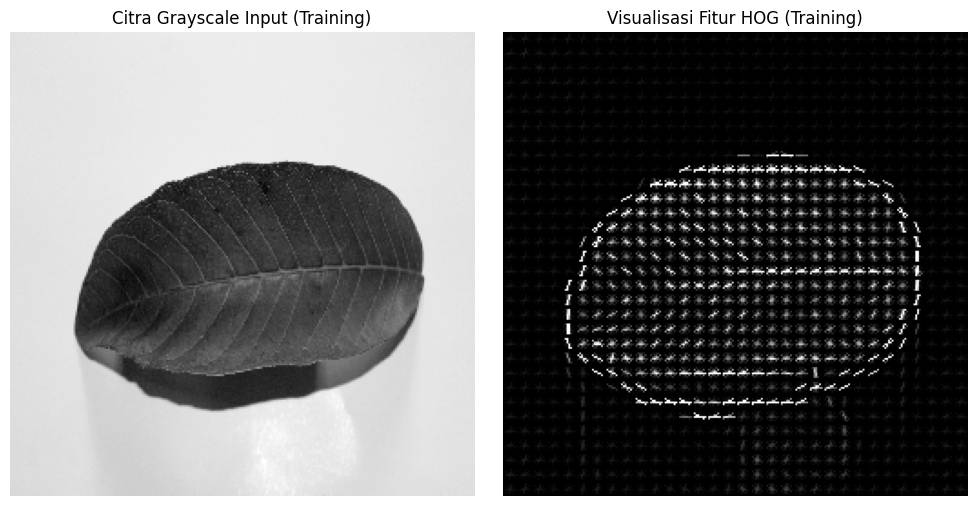

Shape array fitur HOG (Training): (800, 34596)

--- Mengekstrak fitur HOG untuk semua citra Testing ---
Shape array fitur HOG (Testing): (200, 34596)


In [11]:
# @title 4.1.2. Demonstrasi dan Aplikasi Fitur HOG
# Ekstraksi fitur HOG untuk semua citra training
hog_features_train_list = []
if 'preprocessed_images_train_gray' in globals() and len(preprocessed_images_train_gray) > 0:
    print("\n--- Mengekstrak fitur HOG untuk semua citra Training ---")
    # Demonstrasi pada satu citra training
    sample_idx_hog = 0
    sample_image_for_hog = preprocessed_images_train_gray[sample_idx_hog]

    features_sample_hog, hog_image_sample = extract_hog_features(sample_image_for_hog, visualize=True)
    print(f"Dimensi fitur HOG untuk satu citra training: {features_sample_hog.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image_for_hog, cmap='gray')
    plt.title("Citra Grayscale Input (Training)")
    plt.axis('off')
    hog_image_rescaled = exposure.rescale_intensity(hog_image_sample, in_range=(0, 10))
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title("Visualisasi Fitur HOG (Training)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    for img_gray in preprocessed_images_train_gray:
        hog_feats = extract_hog_features(img_gray)
        hog_features_train_list.append(hog_feats)

    hog_features_train_array = np.array(hog_features_train_list)
    print(f"Shape array fitur HOG (Training): {hog_features_train_array.shape}")
else:
    print("Tidak ada citra training pra-pemrosesan untuk ekstraksi HOG.")


# Ekstraksi fitur HOG untuk semua citra testing
hog_features_test_list = []
if 'preprocessed_images_test_gray' in globals() and len(preprocessed_images_test_gray) > 0:
    print("\n--- Mengekstrak fitur HOG untuk semua citra Testing ---")
    for img_gray in preprocessed_images_test_gray:
        hog_feats = extract_hog_features(img_gray)
        hog_features_test_list.append(hog_feats)

    hog_features_test_array = np.array(hog_features_test_list)
    print(f"Shape array fitur HOG (Testing): {hog_features_test_array.shape}")
else:
    print("Tidak ada citra testing pra-pemrosesan untuk ekstraksi HOG.")


In [12]:
# @title 4.2.1. Fungsi Ekstraksi Fitur Gabor
def build_gabor_kernels(ksize=(31, 31), sigma=5.0, lambd=10.0, gamma=0.5, psi=0):
    """
    Membangun bank filter Gabor dengan berbagai orientasi.
    """
    kernels = []
    for theta_deg in np.arange(0, 180, 45):
        theta_rad = np.deg2rad(theta_deg)
        kernel = cv2.getGaborKernel(ksize, sigma, theta_rad, lambd, gamma, psi, ktype=cv2.CV_32F)
        kernels.append(kernel)
    return kernels

def extract_gabor_features(image, kernels):
    """
    Mengekstrak fitur Gabor dari sebuah citra menggunakan bank kernel.
    Fitur adalah mean dan std dev dari respons setiap filter.
    """
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    all_responses = []
    for kernel in kernels:
        filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        all_responses.append(filtered_image.mean())
        all_responses.append(filtered_image.std())

    return np.array(all_responses)

In [13]:
# @title 4.2.2. Aplikasi Fitur Gabor
# Ekstraksi fitur Gabor untuk semua citra training
gabor_features_train_list = []
if 'preprocessed_images_train_gray' in globals() and len(preprocessed_images_train_gray) > 0:
    print("\n--- Mengekstrak fitur Gabor untuk semua citra Training ---")
    gabor_kernels = build_gabor_kernels(ksize=(15,15), sigma=4.0, lambd=10.0, gamma=0.5, psi=np.pi/2)
    print(f"Jumlah kernel Gabor yang dibangun: {len(gabor_kernels)}")

    for img_gray in preprocessed_images_train_gray:
        gabor_feats = extract_gabor_features(img_gray, gabor_kernels)
        gabor_features_train_list.append(gabor_feats)

    gabor_features_train_array = np.array(gabor_features_train_list)
    print(f"Shape array fitur Gabor (Training): {gabor_features_train_array.shape}")
else:
    print("Tidak ada citra training pra-pemrosesan untuk ekstraksi Gabor.")

# Ekstraksi fitur Gabor untuk semua citra testing
gabor_features_test_list = []
if 'preprocessed_images_test_gray' in globals() and len(preprocessed_images_test_gray) > 0:
    print("\n--- Mengekstrak fitur Gabor untuk semua citra Testing ---")
    # Gunakan kernel Gabor yang sama seperti untuk training
    gabor_kernels = build_gabor_kernels(ksize=(15,15), sigma=4.0, lambd=10.0, gamma=0.5, psi=np.pi/2)
    for img_gray in preprocessed_images_test_gray:
        gabor_feats = extract_gabor_features(img_gray, gabor_kernels)
        gabor_features_test_list.append(gabor_feats)

    gabor_features_test_array = np.array(gabor_features_test_list)
    print(f"Shape array fitur Gabor (Testing): {gabor_features_test_array.shape}")
else:
    print("Tidak ada citra testing pra-pemrosesan untuk ekstraksi Gabor.")



--- Mengekstrak fitur Gabor untuk semua citra Training ---
Jumlah kernel Gabor yang dibangun: 4
Shape array fitur Gabor (Training): (800, 8)

--- Mengekstrak fitur Gabor untuk semua citra Testing ---
Shape array fitur Gabor (Testing): (200, 8)



--- Menampilkan Respons Beberapa Kernel Gabor pada Citra Contoh ---


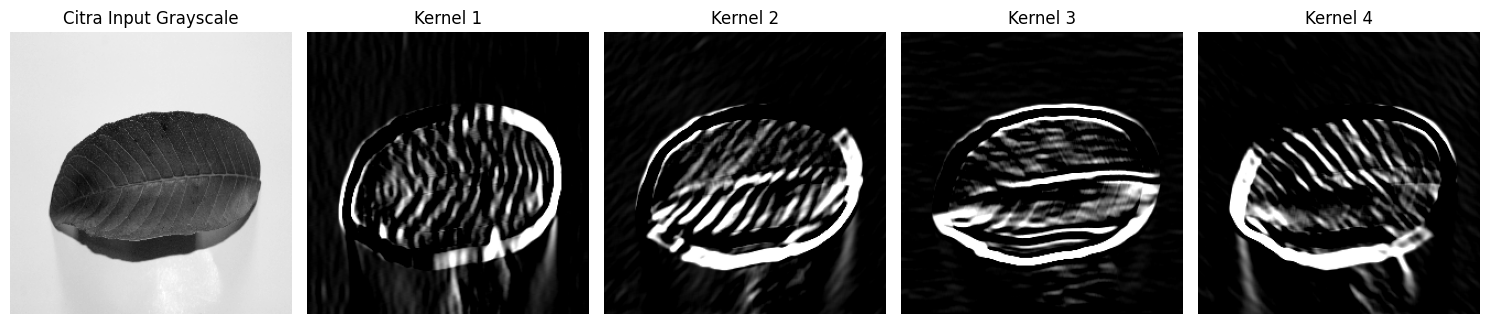

In [14]:
# prompt: menampilkan respons beberapa kernel Gabor pada citra daun.

# @title 4.2.3. Menampilkan Respons Beberapa Kernel Gabor pada Citra Contoh
if 'preprocessed_images_train_gray' in globals() and len(preprocessed_images_train_gray) > 0 and 'gabor_kernels' in globals():
    print("\n--- Menampilkan Respons Beberapa Kernel Gabor pada Citra Contoh ---")

    sample_idx_gabor = 0 # Indeks citra contoh (misalnya, citra pertama dari training)
    sample_image_for_gabor = preprocessed_images_train_gray[sample_idx_gabor]

    # Tampilkan citra asli (grayscale)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(gabor_kernels) + 1, 1)
    plt.imshow(sample_image_for_gabor, cmap='gray')
    plt.title("Citra Input Grayscale")
    plt.axis('off')

    # Tampilkan respons dari beberapa kernel Gabor
    for i, kernel in enumerate(gabor_kernels):
        # Menerapkan filter Gabor pada citra
        filtered_image = cv2.filter2D(sample_image_for_gabor, cv2.CV_8UC3, kernel)

        plt.subplot(1, len(gabor_kernels) + 1, i + 2)
        plt.imshow(filtered_image, cmap='gray')
        plt.title(f"Kernel {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

elif not 'preprocessed_images_train_gray' in globals() or len(preprocessed_images_train_gray) == 0:
    print("Tidak ada citra training pra-pemrosesan yang tersedia untuk demonstrasi respons Gabor.")
elif not 'gabor_kernels' in globals():
    print("Kernel Gabor belum dibuat. Pastikan sel 4.2.1 dan 4.2.2 sudah dijalankan.")
else:
    print("Tidak dapat menampilkan respons Gabor. Periksa variabel global.")

In [15]:
# @title 4.3.1. Fungsi Ekstraksi Fitur CNN (Transfer Learning)
def get_cnn_feature_extractor(model_name='MobileNetV2', input_shape=(256, 256, 3)):
    """
    Memuat model CNN pre-trained sebagai ekstraktor fitur.
    """
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        model = Model(inputs=base_model.input, outputs=x)
    else:
        raise ValueError("Model name not supported yet. Choose 'MobileNetV2'.")
    return model

def extract_cnn_features(image_gray, cnn_model):
    """
    Mengekstrak fitur CNN dari citra grayscale.
    Citra grayscale akan diubah menjadi 3 channel dan dipra-pemroses.
    """
    image_rgb_like = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    image_array = img_to_array(image_rgb_like)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = mobilenet_preprocess_input(image_array)
    features = cnn_model.predict(image_array, verbose=0)
    return features.flatten()

In [16]:
# @title 4.3.2. Aplikasi Fitur CNN
# Ekstraksi fitur CNN untuk semua citra training
cnn_features_train_list = []
if 'preprocessed_images_train_gray' in globals() and len(preprocessed_images_train_gray) > 0:
    print("\n--- Mengekstrak fitur CNN untuk semua citra Training ---")
    cnn_feature_extractor = get_cnn_feature_extractor(input_shape=(256, 256, 3))
    print("Model CNN (MobileNetV2) untuk ekstraksi fitur berhasil dimuat.")
    for img_gray in preprocessed_images_train_gray:
        cnn_feats = extract_cnn_features(img_gray, cnn_feature_extractor)
        cnn_features_train_list.append(cnn_feats)

    cnn_features_train_array = np.array(cnn_features_train_list)
    print(f"Shape array fitur CNN (Training): {cnn_features_train_array.shape}")
else:
    print("Tidak ada citra training pra-pemrosesan untuk ekstraksi CNN.")

# Ekstraksi fitur CNN untuk semua citra testing
cnn_features_test_list = []
if 'preprocessed_images_test_gray' in globals() and len(preprocessed_images_test_gray) > 0:
    print("\n--- Mengekstrak fitur CNN untuk semua citra Testing ---")
    # Gunakan model CNN yang sama seperti untuk training
    cnn_feature_extractor = get_cnn_feature_extractor(input_shape=(256, 256, 3))
    for img_gray in preprocessed_images_test_gray:
        cnn_feats = extract_cnn_features(img_gray, cnn_feature_extractor)
        cnn_features_test_list.append(cnn_feats)

    cnn_features_test_array = np.array(cnn_features_test_list)
    print(f"Shape array fitur CNN (Testing): {cnn_features_test_array.shape}")
else:
    print("Tidak ada citra testing pra-pemrosesan untuk ekstraksi CNN.")



--- Mengekstrak fitur CNN untuk semua citra Training ---


<ipython-input-15-020dc32862b6>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model CNN (MobileNetV2) untuk ekstraksi fitur berhasil dimuat.
Shape array fitur CNN (Training): (800, 1280)

--- Mengekstrak fitur CNN untuk semua citra Testing ---
Shape array fitur CNN (Testing): (200, 1280)


In [17]:
# prompt: menampilkan gambar diagram alur arsitektur ekstraktor CNN.

# @title 4.3.3. Menampilkan Diagram Alur Arsitektur Ekstraktor CNN
print("\n--- Diagram Alur Arsitektur Ekstraktor Fitur CNN ---")

try:
    # Pastikan model cnn_feature_extractor sudah dibuat di langkah 4.3.1/4.3.2
    if 'cnn_feature_extractor' in globals() and cnn_feature_extractor is not None:
        # Import necessary libraries for plotting model
        from tensorflow.keras.utils import plot_model
        import pydotplus
        import graphviz

        # Anda mungkin perlu menginstal graphviz dan pydotplus
        # !pip install graphviz pydotplus

        # Output the model plot to a file (e.g., PNG)
        # Anda bisa menyimpannya di Google Drive jika ingin permanen
        plot_file_path = '/content/cnn_feature_extractor_architecture.png'
        plot_model(cnn_feature_extractor, to_file=plot_file_path, show_shapes=True, show_layer_names=True, rankdir='TB') # rankdir='TB' for top-to-bottom layout

        # Display the image in the notebook
        from IPython.display import Image
        print(f"Diagram arsitektur disimpan ke: {plot_file_path}")
        Image(filename=plot_file_path)

    else:
        print("Model CNN (cnn_feature_extractor) belum dibuat. Pastikan Anda telah menjalankan sel 4.3.1 atau 4.3.2.")
except Exception as e:
    print(f"Gagal menampilkan diagram arsitektur: {e}")
    print("Pastikan Anda telah menginstal 'graphviz' dan 'pydotplus'.")
    print("Coba jalankan:")
    print("!pip install graphviz pydotplus")
    print("Dan pastikan sudah mengaktifkan rendering graphviz jika diperlukan.")




--- Diagram Alur Arsitektur Ekstraktor Fitur CNN ---
Diagram arsitektur disimpan ke: /content/cnn_feature_extractor_architecture.png


In [18]:
# @title 4.4.1. Fungsi Kombinasi dan Normalisasi Fitur

def combine_features(features_list):
    """
    Menggabungkan daftar array fitur secara horizontal (konkatenasi).
    Memastikan semua array dalam daftar tidak kosong sebelum konkatenasi.
    """
    valid_features = [f for f in features_list if f.size > 0]
    if not valid_features:
        return np.array([])

    # Cek apakah semua fitur valid memiliki jumlah sampel yang sama (jumlah baris)
    num_samples = valid_features[0].shape[0] # Ambil jumlah sampel dari array pertama
    if not all(f.shape[0] == num_samples for f in valid_features):
        print("Error: Jumlah sampel tidak cocok antar set fitur yang akan digabungkan.")
        for i, f_arr in enumerate(features_list): # Gunakan features_list asli untuk debugging lebih baik
            if f_arr.size > 0: # Hanya tampilkan yang tidak kosong
                print(f"Shape fitur ke-{i}: {f_arr.shape}")
        return np.array([])

    return np.concatenate(valid_features, axis=1)

# Inisialisasi array fitur gabungan untuk training dan testing
features_hog_gabor_train = np.array([])
features_hog_cnn_train = np.array([])
features_hog_gabor_cnn_train = np.array([])

features_hog_gabor_test = np.array([])
features_hog_cnn_test = np.array([])
features_hog_gabor_cnn_test = np.array([])


print("\n--- Kombinasi Fitur Training ---")
can_combine_hog_gabor_train = hog_features_train_array.size > 0 and gabor_features_train_array.size > 0
can_combine_hog_cnn_train = hog_features_train_array.size > 0 and cnn_features_train_array.size > 0
can_combine_all_train = hog_features_train_array.size > 0 and gabor_features_train_array.size > 0 and cnn_features_train_array.size > 0

if can_combine_hog_gabor_train:
    if hog_features_train_array.shape[0] == gabor_features_train_array.shape[0]:
        features_hog_gabor_train = combine_features([hog_features_train_array, gabor_features_train_array])
        if features_hog_gabor_train.size > 0: print(f"Shape fitur HOG+Gabor (Training): {features_hog_gabor_train.shape}")
    else:
        print("Tidak dapat menggabungkan HOG+Gabor (Training): jumlah sampel tidak cocok.")
else:
    print("Tidak dapat menggabungkan HOG+Gabor (Training): satu atau kedua array fitur kosong.")

if can_combine_hog_cnn_train:
    if hog_features_train_array.shape[0] == cnn_features_train_array.shape[0]:
        features_hog_cnn_train = combine_features([hog_features_train_array, cnn_features_train_array])
        if features_hog_cnn_train.size > 0: print(f"Shape fitur HOG+CNN (Training): {features_hog_cnn_train.shape}")
    else:
        print("Tidak dapat menggabungkan HOG+CNN (Training): jumlah sampel tidak cocok.")
else:
    print("Tidak dapat menggabungkan HOG+CNN (Training): satu atau kedua array fitur kosong.")

if can_combine_all_train:
    if hog_features_train_array.shape[0] == gabor_features_train_array.shape[0] == cnn_features_train_array.shape[0]:
        features_hog_gabor_cnn_train = combine_features([hog_features_train_array, gabor_features_train_array, cnn_features_train_array])
        if features_hog_gabor_cnn_train.size > 0: print(f"Shape fitur HOG+Gabor+CNN (Training): {features_hog_gabor_cnn_train.shape}")
    else:
        print("Tidak dapat menggabungkan HOG+Gabor+CNN (Training): jumlah sampel tidak cocok.")
else:
    print("Tidak dapat menggabungkan HOG+Gabor+CNN (Training): satu atau lebih array fitur kosong.")


print("\n--- Kombinasi Fitur Testing ---")
can_combine_hog_gabor_test = hog_features_test_array.size > 0 and gabor_features_test_array.size > 0
can_combine_hog_cnn_test = hog_features_test_array.size > 0 and cnn_features_test_array.size > 0
can_combine_all_test = hog_features_test_array.size > 0 and gabor_features_test_array.size > 0 and cnn_features_test_array.size > 0

if can_combine_hog_gabor_test:
    if hog_features_test_array.shape[0] == gabor_features_test_array.shape[0]:
        features_hog_gabor_test = combine_features([hog_features_test_array, gabor_features_test_array])
        if features_hog_gabor_test.size > 0: print(f"Shape fitur HOG+Gabor (Testing): {features_hog_gabor_test.shape}")
    else:
        print("Tidak dapat menggabungkan HOG+Gabor (Testing): jumlah sampel tidak cocok.")
else:
    print("Tidak dapat menggabungkan HOG+Gabor (Testing): satu atau kedua array fitur kosong.")

if can_combine_hog_cnn_test:
    if hog_features_test_array.shape[0] == cnn_features_test_array.shape[0]:
        features_hog_cnn_test = combine_features([hog_features_test_array, cnn_features_test_array])
        if features_hog_cnn_test.size > 0: print(f"Shape fitur HOG+CNN (Testing): {features_hog_cnn_test.shape}")
    else:
        print("Tidak dapat menggabungkan HOG+CNN (Testing): jumlah sampel tidak cocok.")
else:
    print("Tidak dapat menggabungkan HOG+CNN (Testing): satu atau kedua array fitur kosong.")

if can_combine_all_test:
    if hog_features_test_array.shape[0] == gabor_features_test_array.shape[0] == cnn_features_test_array.shape[0]:
        features_hog_gabor_cnn_test = combine_features([hog_features_test_array, gabor_features_test_array, cnn_features_test_array])
        if features_hog_gabor_cnn_test.size > 0: print(f"Shape fitur HOG+Gabor+CNN (Testing): {features_hog_gabor_cnn_test.shape}")
    else:
        print("Tidak dapat menggabungkan HOG+Gabor+CNN (Testing): jumlah sampel tidak cocok.")
else:
    print("Tidak dapat menggabungkan HOG+Gabor+CNN (Testing): satu atau lebih array fitur kosong.")


# Normalisasi fitur (PENTING untuk SVM dan KNN) - Sekarang ada scaler terpisah untuk training dan testing
# Fit scaler hanya pada data training dan transformasikan ke data training dan testing

scaler_hog = StandardScaler()
scaled_hog_features_train = scaler_hog.fit_transform(hog_features_train_array) if hog_features_train_array.size > 0 else np.array([])
scaled_hog_features_test = scaler_hog.transform(hog_features_test_array) if hog_features_test_array.size > 0 else np.array([])

scaler_gabor = StandardScaler()
scaled_gabor_features_train = scaler_gabor.fit_transform(gabor_features_train_array) if gabor_features_train_array.size > 0 else np.array([])
scaled_gabor_features_test = scaler_gabor.transform(gabor_features_test_array) if gabor_features_test_array.size > 0 else np.array([])

scaler_cnn = StandardScaler()
scaled_cnn_features_train = scaler_cnn.fit_transform(cnn_features_train_array) if cnn_features_train_array.size > 0 else np.array([])
scaled_cnn_features_test = scaler_cnn.transform(cnn_features_test_array) if cnn_features_test_array.size > 0 else np.array([])

scaler_hog_gabor = StandardScaler()
scaled_hog_gabor_features_train = scaler_hog_gabor.fit_transform(features_hog_gabor_train) if features_hog_gabor_train.size > 0 else np.array([])
scaled_hog_gabor_features_test = scaler_hog_gabor.transform(features_hog_gabor_test) if features_hog_gabor_test.size > 0 else np.array([])

scaler_hog_cnn = StandardScaler()
scaled_hog_cnn_features_train = scaler_hog_cnn.fit_transform(features_hog_cnn_train) if features_hog_cnn_train.size > 0 else np.array([])
scaled_hog_cnn_features_test = scaler_hog_cnn.transform(features_hog_cnn_test) if features_hog_cnn_test.size > 0 else np.array([])

scaler_hog_gabor_cnn = StandardScaler()
scaled_hog_gabor_cnn_features_train = scaler_hog_gabor_cnn.fit_transform(features_hog_gabor_cnn_train) if features_hog_gabor_cnn_train.size > 0 else np.array([])
scaled_hog_gabor_cnn_features_test = scaler_hog_gabor_cnn.transform(features_hog_gabor_cnn_test) if features_hog_gabor_cnn_test.size > 0 else np.array([])

print("\nNormalisasi fitur selesai (jika fitur tersedia).")

if scaled_hog_features_train.size > 0: print(f"Shape HOG ternormalisasi (Training): {scaled_hog_features_train.shape}")
if scaled_hog_features_test.size > 0: print(f"Shape HOG ternormalisasi (Testing): {scaled_hog_features_test.shape}")

if scaled_gabor_features_train.size > 0: print(f"Shape Gabor ternormalisasi (Training): {scaled_gabor_features_train.shape}")
if scaled_gabor_features_test.size > 0: print(f"Shape Gabor ternormalisasi (Testing): {scaled_gabor_features_test.shape}")

if scaled_cnn_features_train.size > 0: print(f"Shape CNN ternormalisasi (Training): {scaled_cnn_features_train.shape}")
if scaled_cnn_features_test.size > 0: print(f"Shape CNN ternormalisasi (Testing): {scaled_cnn_features_test.shape}")

if scaled_hog_gabor_features_train.size > 0: print(f"Shape HOG+Gabor ternormalisasi (Training): {scaled_hog_gabor_features_train.shape}")
if scaled_hog_gabor_features_test.size > 0: print(f"Shape HOG+Gabor ternormalisasi (Testing): {scaled_hog_gabor_features_test.shape}")

if scaled_hog_cnn_features_train.size > 0: print(f"Shape HOG+CNN ternormalisasi (Training): {scaled_hog_cnn_features_train.shape}")
if scaled_hog_cnn_features_test.size > 0: print(f"Shape HOG+CNN ternormalisasi (Testing): {scaled_hog_cnn_features_test.shape}")

if scaled_hog_gabor_cnn_features_train.size > 0: print(f"Shape HOG+Gabor+CNN ternormalisasi (Training): {scaled_hog_gabor_cnn_features_train.shape}")
if scaled_hog_gabor_cnn_features_test.size > 0: print(f"Shape HOG+Gabor+CNN ternormalisasi (Testing): {scaled_hog_gabor_cnn_features_test.shape}")




--- Kombinasi Fitur Training ---
Shape fitur HOG+Gabor (Training): (800, 34604)
Shape fitur HOG+CNN (Training): (800, 35876)
Shape fitur HOG+Gabor+CNN (Training): (800, 35884)

--- Kombinasi Fitur Testing ---
Shape fitur HOG+Gabor (Testing): (200, 34604)
Shape fitur HOG+CNN (Testing): (200, 35876)
Shape fitur HOG+Gabor+CNN (Testing): (200, 35884)

Normalisasi fitur selesai (jika fitur tersedia).
Shape HOG ternormalisasi (Training): (800, 34596)
Shape HOG ternormalisasi (Testing): (200, 34596)
Shape Gabor ternormalisasi (Training): (800, 8)
Shape Gabor ternormalisasi (Testing): (200, 8)
Shape CNN ternormalisasi (Training): (800, 1280)
Shape CNN ternormalisasi (Testing): (200, 1280)
Shape HOG+Gabor ternormalisasi (Training): (800, 34604)
Shape HOG+Gabor ternormalisasi (Testing): (200, 34604)
Shape HOG+CNN ternormalisasi (Training): (800, 35876)
Shape HOG+CNN ternormalisasi (Testing): (200, 35876)
Shape HOG+Gabor+CNN ternormalisasi (Training): (800, 35884)
Shape HOG+Gabor+CNN ternormalis

In [19]:
# @title 5.1.1. Pembagian Data Latih dan Uji (Diperbarui untuk menggunakan data yang sudah terpisah)
# Data sudah terbagi menjadi training dan testing berdasarkan struktur folder.
# Kita hanya perlu menetapkan variabel X_train, X_test, y_train, y_test dari fitur yang sudah diekstrak.

# Dictionary untuk menyimpan data split (sekarang langsung dari data yang diproses)
data_splits = {}

# Penting: Pastikan valid_labels_train_preprocessed dan valid_labels_test_preprocessed
# memiliki jumlah sampel yang sama dengan fitur yang diekstrak.
# Ini seharusnya sudah konsisten karena kita memfilter berdasarkan gambar yang berhasil diproses.

feature_sets_train = {
    "HOG": scaled_hog_features_train,
    "Gabor": scaled_gabor_features_train,
    "CNN": scaled_cnn_features_train,
    "HOG+Gabor": scaled_hog_gabor_features_train,
    "HOG+CNN": scaled_hog_cnn_features_train,
    "HOG+Gabor+CNN": scaled_hog_gabor_cnn_features_train
}

feature_sets_test = {
    "HOG": scaled_hog_features_test,
    "Gabor": scaled_gabor_features_test,
    "CNN": scaled_cnn_features_test,
    "HOG+Gabor": scaled_hog_gabor_features_test,
    "HOG+CNN": scaled_hog_cnn_features_test,
    "HOG+Gabor+CNN": scaled_hog_gabor_cnn_features_test
}

# Sekarang, kita akan mengisi data_splits dengan data yang sudah terpisah
for name in feature_sets_train.keys(): # Loop melalui semua nama set fitur
    X_train_data = feature_sets_train[name]
    y_train_data = valid_labels_train_preprocessed

    X_test_data = feature_sets_test[name]
    y_test_data = valid_labels_test_preprocessed

    if X_train_data.size > 0 and y_train_data.size > 0 and X_test_data.size > 0 and y_test_data.size > 0:
        if len(X_train_data) == len(y_train_data) and len(X_test_data) == len(y_test_data):
            data_splits[name] = (X_train_data, X_test_data, y_train_data, y_test_data)
            print(f"Data split untuk {name} berhasil disiapkan dari folder terpisah.")
            print(f"  X_train shape: {X_train_data.shape}, y_train shape: {y_train_data.shape}")
            print(f"  X_test shape: {X_test_data.shape}, y_test shape: {y_test_data.shape}")
        else:
            print(f"Peringatan: Jumlah sampel fitur dan label tidak cocok untuk {name}.")
    else:
        print(f"Tidak dapat menyiapkan data split untuk {name}: satu atau lebih set data (train/test) kosong.")



Data split untuk HOG berhasil disiapkan dari folder terpisah.
  X_train shape: (800, 34596), y_train shape: (800,)
  X_test shape: (200, 34596), y_test shape: (200,)
Data split untuk Gabor berhasil disiapkan dari folder terpisah.
  X_train shape: (800, 8), y_train shape: (800,)
  X_test shape: (200, 8), y_test shape: (200,)
Data split untuk CNN berhasil disiapkan dari folder terpisah.
  X_train shape: (800, 1280), y_train shape: (800,)
  X_test shape: (200, 1280), y_test shape: (200,)
Data split untuk HOG+Gabor berhasil disiapkan dari folder terpisah.
  X_train shape: (800, 34604), y_train shape: (800,)
  X_test shape: (200, 34604), y_test shape: (200,)
Data split untuk HOG+CNN berhasil disiapkan dari folder terpisah.
  X_train shape: (800, 35876), y_train shape: (800,)
  X_test shape: (200, 35876), y_test shape: (200,)
Data split untuk HOG+Gabor+CNN berhasil disiapkan dari folder terpisah.
  X_train shape: (800, 35884), y_train shape: (800,)
  X_test shape: (200, 35884), y_test shape:

In [20]:
# @title 5.2.1. Inisialisasi dan Pelatihan Model
classifiers = {
    "SVM": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

trained_models = {}
model_predictions = {}

for feature_set_name, split_data in data_splits.items():
    if split_data is None:
        print(f"Skipping pelatihan untuk {feature_set_name} karena data split tidak tersedia.")
        continue

    X_train, X_test, y_train, y_test = split_data
    print(f"\n--- Melatih model untuk set fitur: {feature_set_name} ---")
    trained_models[feature_set_name] = {}
    model_predictions[feature_set_name] = {}

    if X_train.size == 0 or X_test.size == 0:
        print(f"Skipping {feature_set_name} karena data latih atau uji kosong.")
        continue

    for clf_name, clf_template in classifiers.items():
        print(f"  Melatih {clf_name}...")
        if clf_name == "SVM":
            model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
        elif clf_name == "KNN":
            n_samples_train = len(y_train)
            current_n_neighbors = min(5, n_samples_train) if n_samples_train > 0 else 1
            if current_n_neighbors == 0 : current_n_neighbors = 1
            model = KNeighborsClassifier(n_neighbors=current_n_neighbors)
        elif clf_name == "RandomForest":
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            model = clf_template

        model.fit(X_train, y_train)
        trained_models[feature_set_name][clf_name] = model

        y_pred = model.predict(X_test)

        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)
            model_predictions[feature_set_name][clf_name] = (y_test, y_pred, y_pred_proba)
        else:
            model_predictions[feature_set_name][clf_name] = (y_test, y_pred, None)

        print(f"  {clf_name} selesai dilatih dan prediksi dibuat.")

print("\nPelatihan semua model selesai.")



--- Melatih model untuk set fitur: HOG ---
  Melatih SVM...
  SVM selesai dilatih dan prediksi dibuat.
  Melatih KNN...
  KNN selesai dilatih dan prediksi dibuat.
  Melatih RandomForest...
  RandomForest selesai dilatih dan prediksi dibuat.

--- Melatih model untuk set fitur: Gabor ---
  Melatih SVM...
  SVM selesai dilatih dan prediksi dibuat.
  Melatih KNN...
  KNN selesai dilatih dan prediksi dibuat.
  Melatih RandomForest...
  RandomForest selesai dilatih dan prediksi dibuat.

--- Melatih model untuk set fitur: CNN ---
  Melatih SVM...
  SVM selesai dilatih dan prediksi dibuat.
  Melatih KNN...
  KNN selesai dilatih dan prediksi dibuat.
  Melatih RandomForest...
  RandomForest selesai dilatih dan prediksi dibuat.

--- Melatih model untuk set fitur: HOG+Gabor ---
  Melatih SVM...
  SVM selesai dilatih dan prediksi dibuat.
  Melatih KNN...
  KNN selesai dilatih dan prediksi dibuat.
  Melatih RandomForest...
  RandomForest selesai dilatih dan prediksi dibuat.

--- Melatih model untuk

In [21]:
# @title 5.3.1. Contoh Sederhana Hyperparameter Tuning (GridSearchCV untuk SVM pada HOG)
if "HOG" in data_splits and data_splits["HOG"] is not None:
    X_train_hog, _, y_train_hog, _ = data_splits["HOG"]

    if X_train_hog.size > 0 and y_train_hog.size > 0:
        print("\n--- Contoh Hyperparameter Tuning untuk SVM dengan fitur HOG ---")

        param_grid_svm = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01, 0.1],
            'kernel': ['rbf', 'linear']
        }

        n_samples_cv = len(y_train_hog)
        cv_folds = min(3, n_samples_cv) if n_samples_cv > 0 else 1
        if cv_folds < 2:
            print("Tidak cukup sampel untuk cross-validation dengan GridSearchCV. Skipping tuning.")
        else:
            grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42),
                                           param_grid_svm, cv=cv_folds, scoring='accuracy', verbose=0, n_jobs=-1)

            print("Memulai GridSearch untuk SVM (mungkin memakan waktu)...")
            # grid_search_svm.fit(X_train_hog, y_train_hog) # Uncomment untuk menjalankan

            # print(f"Parameter terbaik ditemukan untuk SVM: {grid_search_svm.best_params_}")
            # print(f"Skor akurasi terbaik (cross-validated): {grid_search_svm.best_score_:.4f}")

        print("Contoh GridSearch selesai (atau di-skip jika di-comment atau tidak cukup sampel).")
        print("Catatan: Untuk penelitian sebenarnya, tuning hyperparameter sebaiknya dilakukan untuk semua model dan set fitur.")
    else:
        print("Data HOG (latih) tidak tersedia atau kosong untuk hyperparameter tuning.")
else:
    print("Set fitur 'HOG' tidak ditemukan dalam data_splits atau data split gagal, skipping hyperparameter tuning.")



--- Contoh Hyperparameter Tuning untuk SVM dengan fitur HOG ---
Memulai GridSearch untuk SVM (mungkin memakan waktu)...
Contoh GridSearch selesai (atau di-skip jika di-comment atau tidak cukup sampel).
Catatan: Untuk penelitian sebenarnya, tuning hyperparameter sebaiknya dilakukan untuk semua model dan set fitur.


In [22]:
# @title 5.3.1. Contoh Sederhana Hyperparameter Tuning (GridSearchCV untuk SVM pada HOG)
if "HOG" in data_splits and data_splits["HOG"] is not None:
    X_train_hog, _, y_train_hog, _ = data_splits["HOG"]

    if X_train_hog.size > 0 and y_train_hog.size > 0:
        print("\n--- Contoh Hyperparameter Tuning untuk SVM dengan fitur HOG ---")

        param_grid_svm = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01, 0.1],
            'kernel': ['rbf', 'linear']
        }

        n_samples_cv = len(y_train_hog)
        cv_folds = min(3, n_samples_cv) if n_samples_cv > 0 else 1
        if cv_folds < 2:
            print("Tidak cukup sampel untuk cross-validation dengan GridSearchCV. Skipping tuning.")
        else:
            grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42),
                                           param_grid_svm, cv=cv_folds, scoring='accuracy', verbose=0, n_jobs=-1)

            print("Memulai GridSearch untuk SVM (mungkin memakan waktu)...")
            # grid_search_svm.fit(X_train_hog, y_train_hog) # Uncomment untuk menjalankan

            # print(f"Parameter terbaik ditemukan untuk SVM: {grid_search_svm.best_params_}")
            # print(f"Skor akurasi terbaik (cross-validated): {grid_search_svm.best_score_:.4f}")

        print("Contoh GridSearch selesai (atau di-skip jika di-comment atau tidak cukup sampel).")
        print("Catatan: Untuk penelitian sebenarnya, tuning hyperparameter sebaiknya dilakukan untuk semua model dan set fitur.")
    else:
        print("Data HOG (latih) tidak tersedia atau kosong untuk hyperparameter tuning.")
else:
    print("Set fitur 'HOG' tidak ditemukan dalam data_splits atau data split gagal, skipping hyperparameter tuning.")



--- Contoh Hyperparameter Tuning untuk SVM dengan fitur HOG ---
Memulai GridSearch untuk SVM (mungkin memakan waktu)...
Contoh GridSearch selesai (atau di-skip jika di-comment atau tidak cukup sampel).
Catatan: Untuk penelitian sebenarnya, tuning hyperparameter sebaiknya dilakukan untuk semua model dan set fitur.


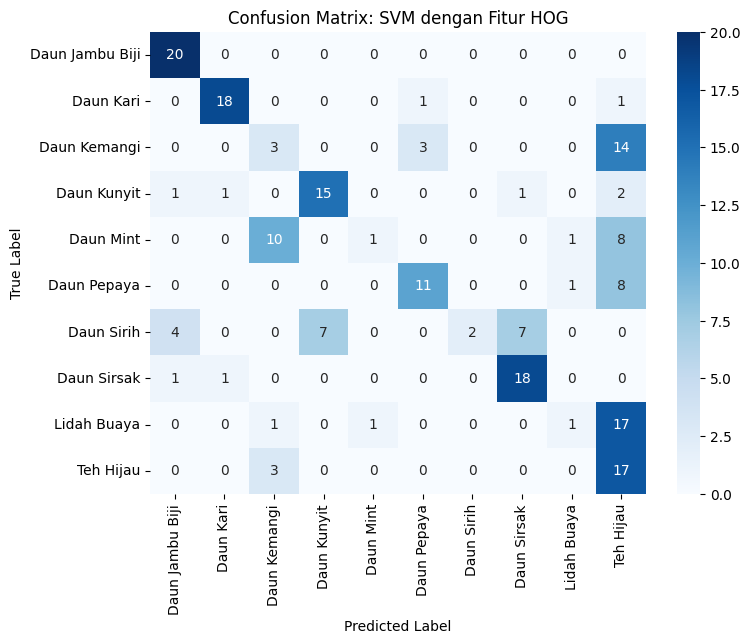

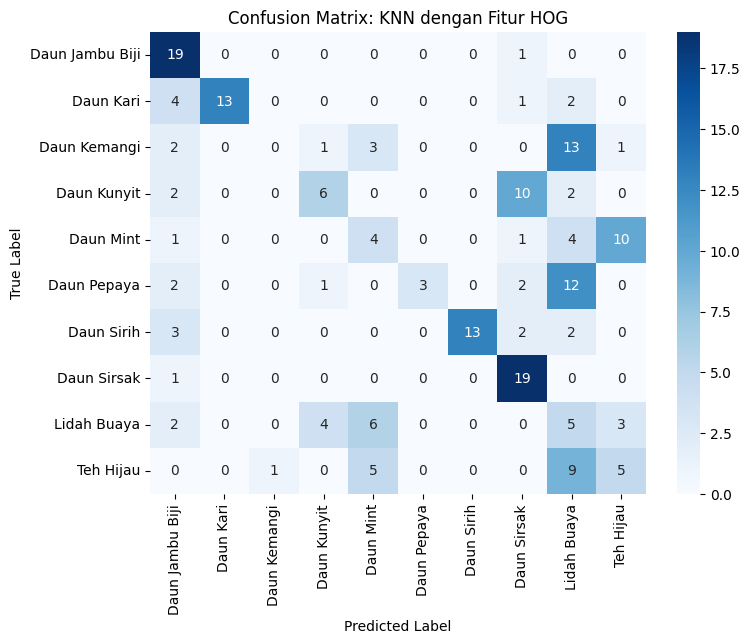

In [23]:
# @title 6.2.1.1. Tampilkan Confusion Matrix (Contoh untuk Model Terbaik atau Model Tertentu)
class_names_original_cm = []
if 'label_encoder' in globals() and hasattr(label_encoder, 'classes_'):
    class_names_original_cm = label_encoder.classes_
elif 'all_class_names' in globals() and all_class_names: # Fallback jika label_encoder tidak ada tapi all_class_names ada
     class_names_original_cm = sorted(list(set(all_class_names)))
else:
    first_valid_y_test = None
    for fs_name_cm, clf_preds_cm_dict in model_predictions.items():
        for clf_name_cm, preds_data_cm in clf_preds_cm_dict.items():
            if preds_data_cm and preds_data_cm[0] is not None and len(preds_data_cm[0]) > 0:
                first_valid_y_test = preds_data_cm[0]
                break
        if first_valid_y_test is not None: break

    if first_valid_y_test is not None and len(np.unique(first_valid_y_test)) > 0:
        num_unique_classes = len(np.unique(first_valid_y_test))
        class_names_original_cm = [f"Kelas {i}" for i in range(num_unique_classes)]
    else:
        class_names_original_cm = ["N/A"]


num_visualize_cm = 2
count_cm = 0

for feature_set_name_cm, clf_predictions_cm in model_predictions.items():
    if count_cm >= num_visualize_cm: break
    for clf_name_cm, preds_data_cm_tuple in clf_predictions_cm.items():
        if count_cm >= num_visualize_cm: break

        if preds_data_cm_tuple is None: continue
        y_test_cm, y_pred_cm, _ = preds_data_cm_tuple

        if y_test_cm is None or y_pred_cm is None or len(y_test_cm) == 0: continue

        current_unique_labels = np.unique(np.concatenate((y_test_cm, y_pred_cm)))
        current_num_classes = len(current_unique_labels)

        plot_class_names = class_names_original_cm
        if 'label_encoder' in globals() and hasattr(label_encoder, 'classes_'):
             # Pastikan plot_class_names sesuai dengan urutan label yang dienkode
             plot_class_names = [label_encoder.inverse_transform([label])[0] for label in sorted(list(current_unique_labels))]
        else: # Fallback jika encoder tidak ada atau tidak sesuai
             plot_class_names = [str(l) for l in sorted(list(current_unique_labels))]


        cm = confusion_matrix(y_test_cm, y_pred_cm, labels=sorted(list(current_unique_labels)) if current_num_classes > 0 else None)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=plot_class_names if current_num_classes > 0 else ["N/A"],
                    yticklabels=plot_class_names if current_num_classes > 0 else ["N/A"])
        plt.title(f"Confusion Matrix: {clf_name_cm} dengan Fitur {feature_set_name_cm}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
        count_cm += 1

if count_cm == 0:
    print("Tidak ada Confusion Matrix yang ditampilkan (mungkin tidak ada prediksi yang valid).")


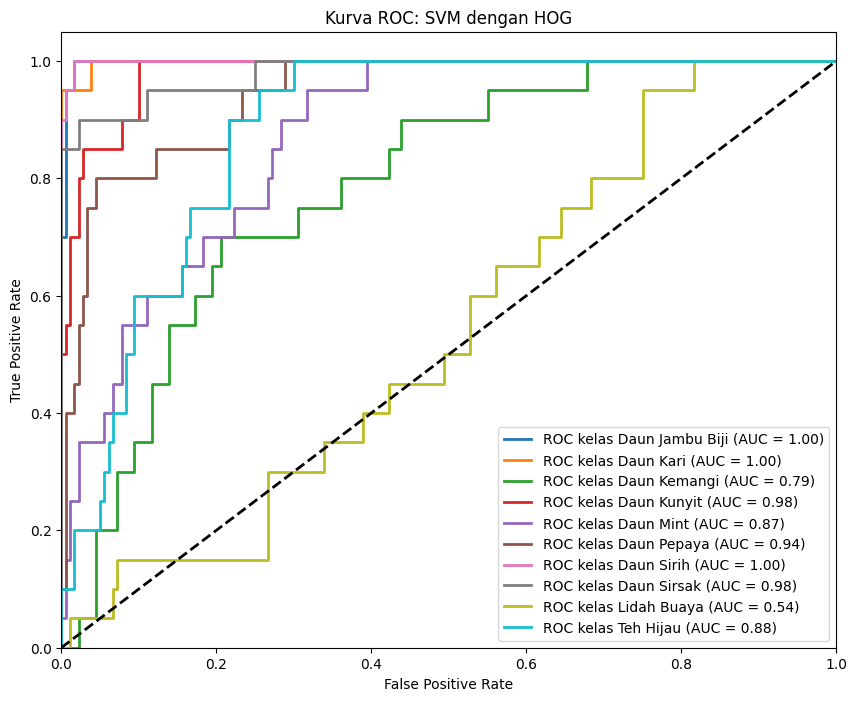

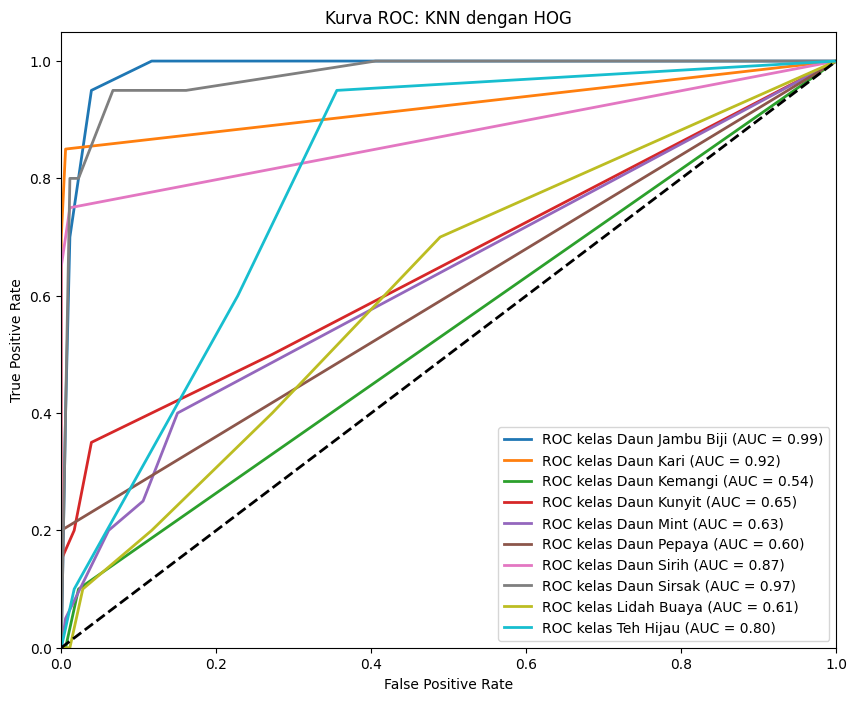

In [24]:
# @title 6.2.2.1. Tampilkan Kurva ROC dan AUC (Contoh)
num_visualize_roc = 2
count_roc = 0

if 'label_encoder' not in globals() or not hasattr(label_encoder, 'classes_'):
    print("Label encoder tidak tersedia atau belum di-fit. Skipping ROC curve plotting.")
else:
    n_classes_roc = len(label_encoder.classes_)

    for feature_set_name_roc, clf_predictions_roc_dict in model_predictions.items():
        if count_roc >= num_visualize_roc: break
        for clf_name_roc, preds_data_roc_tuple in clf_predictions_roc_dict.items():
            if count_roc >= num_visualize_roc: break

            if preds_data_roc_tuple is None: continue
            y_test_roc, _, y_pred_proba_roc = preds_data_roc_tuple

            if y_test_roc is None or y_pred_proba_roc is None or len(y_test_roc) == 0:
                continue

            unique_test_labels = np.unique(y_test_roc)
            current_n_classes_roc = len(unique_test_labels)

            if current_n_classes_roc <= 1:
                continue

            plt.figure(figsize=(10, 8))

            if current_n_classes_roc == 2:
                proba_positive_class = y_pred_proba_roc[:, 1] if y_pred_proba_roc.ndim > 1 and y_pred_proba_roc.shape[1] == 2 else y_pred_proba_roc
                if proba_positive_class.ndim > 1 and proba_positive_class.shape[1] > 1:
                    print(f"Peringatan: Proba untuk kelas positif tidak dapat ditentukan untuk {clf_name_roc} - {feature_set_name_roc}. Skipping ROC.")
                    plt.close()
                    continue

                fpr, tpr, _ = roc_curve(y_test_roc, proba_positive_class, pos_label=unique_test_labels[1])
                roc_auc_val = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'Kurva ROC (AUC = {roc_auc_val:.2f})')

            else:
                y_test_binarized = np.zeros((len(y_test_roc), n_classes_roc))
                valid_indices = y_test_roc < n_classes_roc

                if not np.all(valid_indices):
                    print(f"Peringatan: Ada label di y_test_roc yang di luar jangkauan {n_classes_roc} kelas untuk {clf_name_roc} - {feature_set_name_roc}. Ini bisa menyebabkan error.")
                    y_test_roc_filtered = y_test_roc[valid_indices]
                    y_test_binarized_filtered = np.zeros((len(y_test_roc_filtered), n_classes_roc))
                    for i_filt in range(len(y_test_roc_filtered)):
                        y_test_binarized_filtered[i_filt, y_test_roc_filtered[i_filt]] = 1
                    y_test_binarized = y_test_binarized_filtered
                    y_pred_proba_roc_filtered = y_pred_proba_roc[valid_indices]
                    if y_pred_proba_roc_filtered.shape[0] == 0:
                        plt.close()
                        continue
                else:
                     for i in range(len(y_test_roc)):
                        y_test_binarized[i, y_test_roc[i]] = 1
                     y_pred_proba_roc_filtered = y_pred_proba_roc


                if y_pred_proba_roc_filtered.shape[1] != n_classes_roc:
                    print(f"Peringatan: Jumlah kolom proba ({y_pred_proba_roc_filtered.shape[1]}) tidak sama dengan jumlah kelas ({n_classes_roc}) untuk {clf_name_roc} - {feature_set_name_roc}. Skipping ROC.")
                    plt.close()
                    continue

                fpr = dict()
                tpr = dict()
                roc_auc_dict = dict()

                for i_cls in range(n_classes_roc):
                    if np.sum(y_test_binarized[:, i_cls]) > 0:
                        fpr[i_cls], tpr[i_cls], _ = roc_curve(y_test_binarized[:, i_cls], y_pred_proba_roc_filtered[:, i_cls])
                        roc_auc_dict[i_cls] = auc(fpr[i_cls], tpr[i_cls])
                        plt.plot(fpr[i_cls], tpr[i_cls], lw=2, label=f'ROC kelas {label_encoder.classes_[i_cls]} (AUC = {roc_auc_dict[i_cls]:.2f})')
                    else:
                        pass


            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Kurva ROC: {clf_name_roc} dengan {feature_set_name_roc}')
            plt.legend(loc="lower right")
            plt.show()
            count_roc += 1

if count_roc == 0:
    print("Tidak ada Kurva ROC yang ditampilkan.")


In [25]:
# @title 7. Analisis Komparatif dan Kesimpulan
# Konten ini tidak memerlukan perubahan kode Python. Tetap sebagai teks analisis.

# @title 8.1. Tampilkan Versi Pustaka Utama
import sklearn
import tensorflow
import skimage

print(f"Scikit-learn version: {sklearn.__version__}")
print(f"TensorFlow version: {tensorflow.__version__}")
print(f"Scikit-image version: {skimage.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Scikit-learn version: 1.6.1
TensorFlow version: 2.18.0
Scikit-image version: 0.25.2
OpenCV version: 4.11.0
NumPy version: 2.0.2
Pandas version: 2.2.2
